In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as pil
import keras as kr
import tensorflow as tf

from keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
from keras.applications.vgg19 import preprocess_input
from keras.applications import VGG16, vgg19

The Goal of this code for style transfer is to merge the content of one input image with the style of another input image. In order for this to be effective, we must minimize style loss and content loss of our output image. 

In [93]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#automates image resizing so our image isn't too big and we can load images with same size

style_path=r'chalermchai1.jpg'
content_path =r'nyc.jpg'

content_weight= 1
style_weight=.001
variation_weight=1

w1, h1 = load_img(content_path).size
height = 400
width = int(w1 * height / h1)


In [0]:
#shows unprocessed image
def show_unprocessed(content_path, style_path):
    plt.figure(figsize=(12,12))

    #Uint8 is important because it keeps our colors in visible spectrum between 0 and 255
    content = load_img(content_path)#.astype('uint8')
    style = load_img(style_path)#.astype('uint8')

    plt.subplot(1, 2, 1)
    plt.imshow(content)

    plt.subplot(1, 2, 2)
    plt.imshow(style)
    plt.show()

In [0]:
#Processes image for vgg19
def process_img(path):
    
    from keras.applications import vgg19
    img = load_img(path, target_size=(height, width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


In [0]:
#Content Loss Function to minimize
def content_loss(input_im, output_im):
    return K.mean(K.square(input_im-output_im))


In [0]:
#Defining Style Loss Function
#Style Representation requires measuring the spatial correlation of values produced by a gram matrix. At different layers of 
#the image, we can find correlations zoomed in and out of both images.

#First need to make an function for creating gram matrices (spatial correlation matrix). 
def gram_matrix(img):

    assert K.ndim(img) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(img)
    else:
        features = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
    gmat = K.dot(features, K.transpose(features))
    return gmat


#Style loss can be calculated as the mean squared error of the style vs. child image
def style_loss(style_img, gen_img):
    num_channels= 3
    im_size = height * width
    return K.mean(K.square(gram_matrix(style_img)-gram_matrix(gen_img))) 
    / (4*(num_channels**2)*(im_size**2))
#num_channels and im_size will be global

In [0]:
#Defining Variation Loss- Variation loss attempts to minimize pixelation and produce an output image that is smooth.
def variation_loss(matrix, power):
    #Pixels close to each other are compared by their color value and differences are minimized.

    assert K.ndim(matrix) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            matrix[:, :, :height - 1, :width - 1] - matrix[:, :, 1:, :width - 1])
        b = K.square(
            matrix[:, :, :height - 1, :width - 1] - matrix[:, :, :height - 1, 1:])
    else:
        a = K.square(
            matrix[:, :height - 1, :width - 1, :] - matrix[:, 1:, :width - 1, :])
        b = K.square(
            matrix[:, :height - 1, :width - 1, :] - matrix[:, :height - 1, 1:, :])
        
    return K.sum(K.pow(a + b, power)) 

In [0]:
#We should use intermediate layers becuase this will allow us to connect the output of the first layer as an input to the
#next later. 

In [0]:
style_img= process_img(style_path)
content_img= process_img(content_path)

im_size= height * width

style_image= K.variable(style_img)
content_image=K.variable(content_img)


if K.image_data_format() == 'channels_first':
    combination_img = K.placeholder((1, 3, height, width))
else:
    combination_img = K.placeholder((1, height, width, 3))


tensor = K.concatenate([content_image,
                              style_image,
                              combination_img], axis=0)

model = vgg19.VGG19(input_tensor=tensor,
                    weights='imagenet', include_top=False)
model_layers = dict([(layer.name, layer.output) for layer in model.layers])

loss = K.variable(0.0)
layer_features = model_layers['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_loss(base_image_features, combination_features) *content_weight

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = model_layers[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features) *style_weight
    loss = loss + (1 / len(feature_layers)) * sl 
loss = loss + variation_loss(combination_img,3) 

# Start compiling

The limited BFGS algorithm is known as the best algorithm for style transfer
#research BFGS, newton method

In [0]:


class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

def eval_loss_and_grads(combination_image):
    #evaluates loss and gradients

    if K.image_data_format() == 'channels_first':
        combination_image = combination_image.reshape((1, 3, height, width))
    else:
        combination_image = combination_image.reshape((1, height, width, 3))
    outs = func_outputs([combination_image])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:

def deprocess_and_save(x, name, i):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, height, width))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((height, width, 3))
    
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # convert to RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    save_img(r'{}{}.jpg'.format(name, i),x)
    

# New Section

In [0]:
x_opt = process_img(r'nyc.jpg')

combination_image = np.random.uniform(0, 255, (1, height, width, 3)) - 128


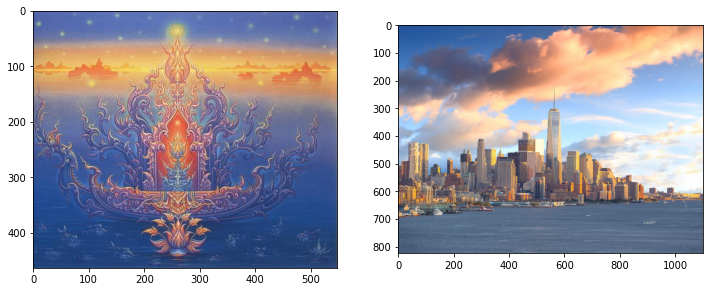

iteration: 0
Loss: 280471210000000.0
Iteration 0 took 4.797789096832275 seconds
iteration: 1
Loss: 146892650000000.0
Iteration 1 took 3.6107897758483887 seconds
iteration: 2
Loss: 81456560000000.0
Iteration 2 took 3.980074882507324 seconds
iteration: 3
Loss: 63366400000000.0
Iteration 3 took 3.9542131423950195 seconds
iteration: 4
Loss: 52821630000000.0
Iteration 4 took 3.838303565979004 seconds
iteration: 5
Loss: 46274620000000.0
Iteration 5 took 3.983597755432129 seconds
iteration: 6
Loss: 41683094000000.0
Iteration 6 took 3.9337046146392822 seconds
iteration: 7
Loss: 38693680000000.0
Iteration 7 took 3.8583953380584717 seconds
iteration: 8
Loss: 36445490000000.0
Iteration 8 took 4.062882423400879 seconds
iteration: 9
Loss: 33937326000000.0
Iteration 9 took 4.055074453353882 seconds


In [117]:
from scipy.optimize import fmin_l_bfgs_b
import time

evaluator = Evaluator()
iterations = 10

num_channels= 3


show_unprocessed(style_path, content_path)

style_img= process_img(style_path)
content_img= process_img(content_path)

im_size= height * width

style_image= K.variable(style_img)
content_image=K.variable(content_img)


#Define Loss and Gradient to Optimize: Loss on combination image
grads = K.gradients(loss, combination_img)

# Define the function outputs
outputs = [loss]
outputs += grads
func_outputs = K.function([combination_img], outputs)

for i in range(iterations):
    print('iteration:',i)
    start = time.time()
    x_opt, min_, info = fmin_l_bfgs_b(evaluator.loss, x_opt.flatten() ,
                                                     fprime=evaluator.grads, maxfun=20)
    xcopy = x_opt.copy()
    deprocess_and_save(xcopy, 'first', i)
    print('Loss:', min_)
    end = time.time()
    print('Iteration {} took {} seconds'.format(i, end - start))